In [1]:
import os
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

In [2]:
# Ścieżka do folderu z danymi
base_dir = "C:\\Users\\przem\\Desktop\\PWR\\CNN\\xray"

categories = ["NORMAL", "PNEUMONIA"]
img_size = (224, 224)  # Wymiary obrazu
def load_images(data_dir, categories, img_size):
    data = []
    labels = []
    
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)
        
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                # Wczytaj obraz w skali szarości
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                # Przeskaluj do odpowiedniego rozmiaru
                img = cv2.resize(img, img_size)
                # Normalizuj do zakresu [0, 1]
                img = img / 255.0
                # Dodaj wymiar kanału
                img = np.expand_dims(img, axis=-1)
                
                data.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Błąd podczas wczytywania obrazu {img_path}: {e}")
    
    return np.array(data), np.array(labels)

# Wczytanie danych
image_data, image_labels = load_images(base_dir, categories, img_size)
print(f"Shape of data: {image_data.shape}")
print(f"Shape of labels: {image_labels.shape}")


Shape of data: (5856, 224, 224, 1)
Shape of labels: (5856,)


In [3]:
# Podział danych na train i test
image_data_train, image_data_temp, image_labels_train, image_labels_temp = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, stratify=image_labels)

# Podział danych tymczasowych na val i test
image_data_val, image_data_test, image_labels_val, image_labels_test = train_test_split(image_data_temp, image_labels_temp, test_size=0.5, random_state=42, stratify=image_labels_temp)

print(f"Train set: {image_data_train.shape}, Validation set: {image_data_val.shape}, Test set: {image_data_test.shape}")


Train set: (4099, 224, 224, 1), Validation set: (878, 224, 224, 1), Test set: (879, 224, 224, 1)


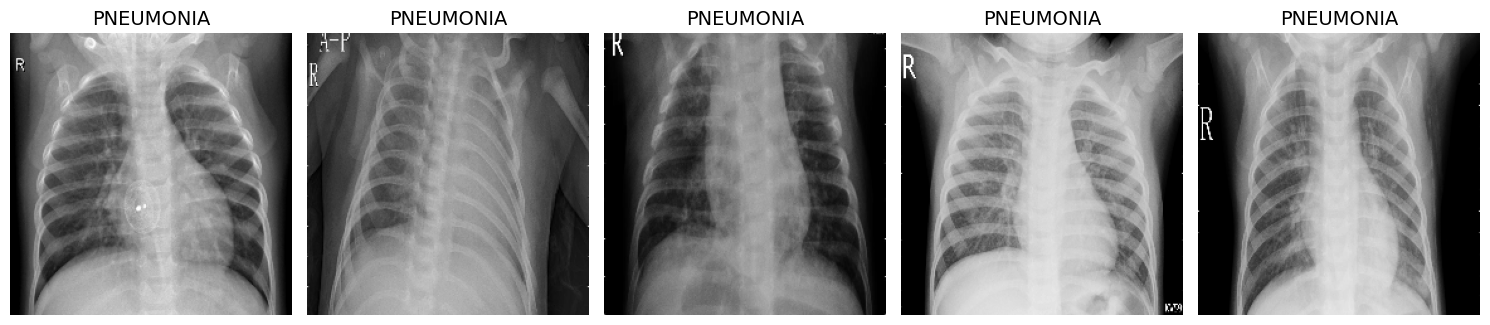

In [4]:
def display_sample_images(images, labels, categories, num_images=5):
    plt.figure(figsize=(15, 5))
    indices = np.random.choice(len(images), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        img = images[idx].squeeze()  # Usuwa wymiar kanału, jeśli istnieje
        label = categories[labels[idx]]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label, fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# Wyświetlanie oryginalnych obrazków
display_sample_images(image_data_train, image_labels_train, categories, num_images=5)

In [5]:
# ImageDataGenerator dla augmentacji danych
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Przygotowanie generatora dla zbioru treningowego
train_generator = datagen.flow(image_data_train, image_labels_train, batch_size=32)

# Normalizacja walidacyjnych i testowych
val_generator = ImageDataGenerator().flow(image_data_val, image_labels_val, batch_size=32)
test_generator = ImageDataGenerator().flow(image_data_test, image_labels_test, batch_size=32)

In [6]:
# Funkcja do konwersji obrazów 1-kanałowych na 3-kanałowe
def convert_to_rgb(images):
    return np.repeat(images, 3, axis=-1)

# Konwersja danych do formatu (224, 224, 3)
image_data_train_rgb = convert_to_rgb(image_data_train)
image_data_val_rgb = convert_to_rgb(image_data_val)
image_data_test_rgb = convert_to_rgb(image_data_test)

print(f"Train data shape (RGB): {image_data_train_rgb.shape}")
print(f"Validation data shape (RGB): {image_data_val_rgb.shape}")
print(f"Test data shape (RGB): {image_data_test_rgb.shape}")

Train data shape (RGB): (4099, 224, 224, 3)
Validation data shape (RGB): (878, 224, 224, 3)
Test data shape (RGB): (879, 224, 224, 3)


In [7]:
# Tworzenie tf.data.Dataset
def create_dataset(images, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(image_data_train_rgb, image_labels_train)
val_dataset = create_dataset(image_data_val_rgb, image_labels_val)
test_dataset = create_dataset(image_data_test_rgb, image_labels_test)

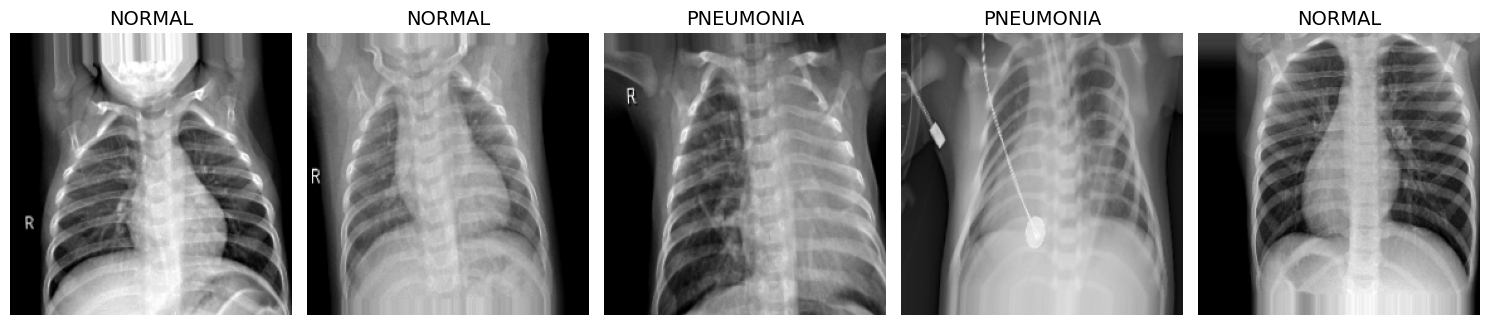

In [8]:
def display_augmented_images(datagen, images, labels, categories, num_images=5):
    plt.figure(figsize=(15, 5))    
    augmented_data = datagen.flow(images, labels, batch_size=num_images)
    augmented_images, augmented_labels = next(augmented_data)
    
    for i in range(num_images):
        img = augmented_images[i].squeeze()  # Usuwa wymiar kanału, jeśli istnieje
        label = categories[int(augmented_labels[i])]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label, fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Wyświetlanie obrazków po augmentacji
display_augmented_images(datagen, image_data_train, image_labels_train, categories, num_images=5)

In [9]:
# Wczytanie bazy VGG16
base_model1 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling="max")
base_model1.summary()

# Zamrożenie warstw bazowego modelu
base_model1.trainable = False

# Dodanie warstw wierzchnich
model = Sequential([
    base_model1,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Liczba wyjść odpowiada liczbie kategorii
])

# Kompilacja modelu
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Tworzenie obiektu EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=3,                
    restore_best_weights=True  
)

# Trenowanie modelu z wagami klas
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)
# Ocena modelu
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.2f}")

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 476s 4s/step - accuracy: 0.7870 - loss: 0.4743 - val_accuracy: 0.9100 - val_loss: 0.2213
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.9230 - loss: 0.2096 - val_accuracy: 0.9260 - val_loss: 0.1794
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 464s 4s/step - accuracy: 0.9420 - loss: 0.1661 - val_accuracy: 0.9362 - val_loss: 0.1573
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 455s 4s/step - accuracy: 0.9470 - loss: 0.1471 - val_accuracy: 0.9419 - val_loss: 0.1497
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 453s 4s/step - accuracy: 0.9437 - loss: 0.1510 - val_accuracy: 0.9431 - val_loss: 0.1449
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 453s 4s/step - accuracy: 0.9529 - loss: 0.1251 - val_accuracy: 0.9453 - val_loss: 0.1412
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 453s 4s/step - accuracy: 0.9489 - loss: 0.1342 - val_accuracy: 0.9453 - val_loss: 0.1389
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 453s 4s/step - accuracy: 0.9555 - loss: 0.1298 - val_accu

28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step


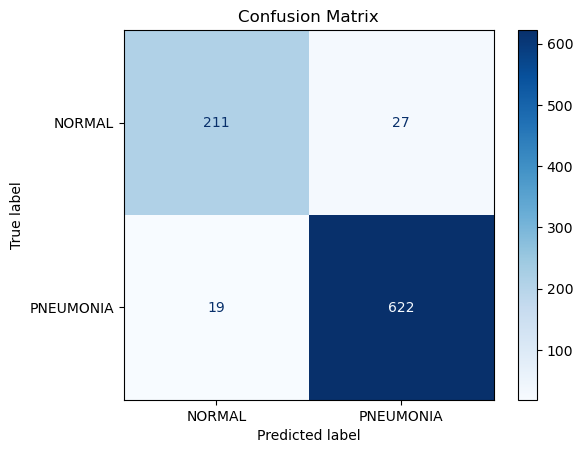

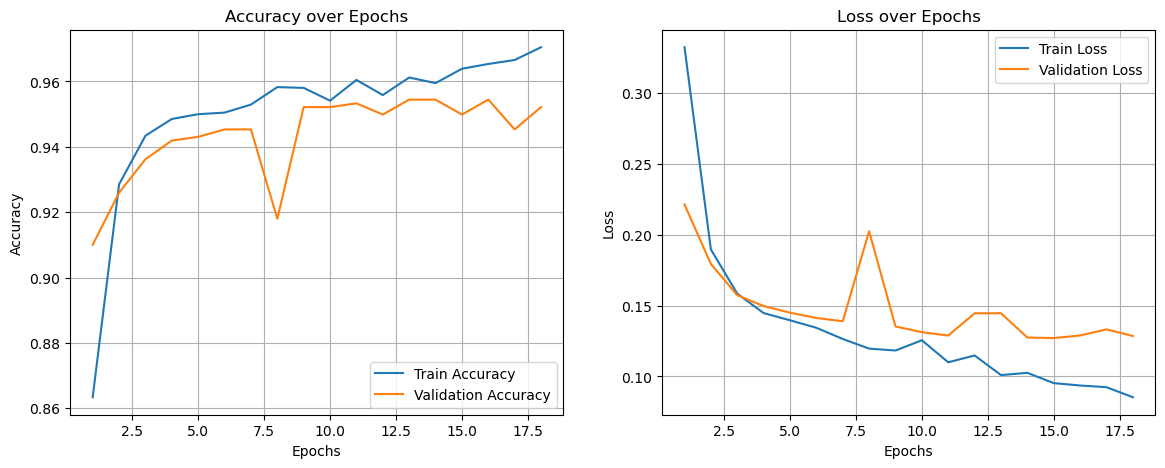

28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9409 - loss: 0.1603
Test Accuracy: 0.95
Classification Report:

              precision    recall  f1-score   support

      NORMAL     0.9174    0.8866    0.9017       238
   PNEUMONIA     0.9584    0.9704    0.9643       641

    accuracy                         0.9477       879
   macro avg     0.9379    0.9285    0.9330       879
weighted avg     0.9473    0.9477    0.9474       879

Precision: 0.9174, Recall: 0.8866, F1-score: 0.9017


In [17]:
# Konwersja obrazów testowych do RGB
image_data_test_rgb = convert_to_rgb(image_data_test)

# Użyj prognoz ciągłych i zaokrąglij je
image_labels_pred = np.round(model.predict(image_data_test_rgb)).astype(int)

# Prawdziwe etykiety na zbiorze testowym
image_labels_true = []
for image_data, image_labels in test_dataset:
    image_labels_true.extend(image_labels.numpy())  # Zbieranie prawdziwych etykiet

# Konwersja do numpy array
image_labels_true = np.array(image_labels_test)

# Obliczanie macierzy pomyłek
cm = confusion_matrix(image_labels_true, image_labels_pred)

# Wyświetlanie macierzy pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Funkcja do rysowania wykresów
def plot_training_history(history):
    # Wyciągnięcie danych z historii treningu
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)
    
    # Wykres dokładności
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid()

    # Wykres funkcji straty
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid()

    plt.show()

# Wywołanie funkcji do rysowania wykresów
plot_training_history(history)

# Ewaluacja modelu
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Wyświetlanie dodatkowych metryk
report = classification_report(image_labels_true, image_labels_pred, target_names=["NORMAL", "PNEUMONIA"], digits=4)
print("Classification Report:\n")
print(report)

# Dodatkowe metryki
precision = report.split('\n')[2].split()[1]
recall = report.split('\n')[2].split()[2]
f1 = report.split('\n')[2].split()[3]
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")
